In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
# IPythonConsole.ipython_useSVG=False

In [2]:
def label(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

In [3]:
from rdkit.Chem.Lipinski import NumRotatableBonds, NHOHCount
test = Chem.MolFromMolFile('Resources/funky_single.mol')
print(NumRotatableBonds(test))
print(NHOHCount(test))
label(test)

OSError: Bad input file Resources/funky_single.mol

6


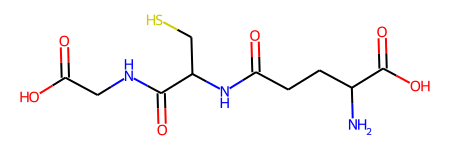

In [4]:
test2 = Chem.MolFromSmiles('C(CC(=O)NC(CS)C(=O)NCC(=O)O)C(C(=O)O)N')
print(NHOHCount(test2))
test2

In [5]:
def _diagonalize(A):
    eigenvalues_of_A, eigenvectors_of_A = np.linalg.eig(A)
    B = eigenvectors_of_A[:,abs(eigenvalues_of_A).argsort()]   
    diagonal_matrix= np.dot(np.linalg.inv(B), np.dot(A, B))
    return diagonal_matrix

In [6]:
Chem.GetDistanceMatrix(test)

array([[0., 1., 1., 2., 3., 3., 2., 3.],
       [1., 0., 1., 1., 2., 2., 1., 2.],
       [1., 1., 0., 2., 3., 3., 2., 3.],
       [2., 1., 2., 0., 1., 1., 2., 1.],
       [3., 2., 3., 1., 0., 1., 3., 2.],
       [3., 2., 3., 1., 1., 0., 3., 2.],
       [2., 1., 2., 2., 3., 3., 0., 3.],
       [3., 2., 3., 1., 2., 2., 3., 0.]])

In [7]:
def _alignment_indexes(mol, reactive_atoms, debug=True):
    '''
    Return the indexes to align the molecule to, given a list of
    atoms that should be reacting. List is composed by reactive atoms
    plus adjacent atoms.
    :param mol: rdkit Mol class molecule object
    :param reactive atoms: int or list of ints

    '''
    matrix = Chem.GetAdjacencyMatrix(mol)
    graph = nx.from_numpy_matrix(matrix)

    if type(reactive_atoms) is int:
        indexes = list([(a, b) for a, b in graph.adjacency()][reactive_atoms][1].keys())
        indexes.append(reactive_atoms)
        if debug: print('DEBUG--> Alignment indexes are', indexes)
        return indexes

    elif len(reactive_atoms) > 1:
        indexes = set()
        for atom in reactive_atoms:
            indexes |= set(list([(a, b) for a, b in graph.adjacency()][atom][1].keys()))
            indexes.add(atom)
        if debug: print('DEBUG--> Alignment indexes are', list(indexes))
        return list(indexes)


In [6]:
import networkx as nx
mol = Chem.MolFromMolFile('Resources/funky_single.mol')
reactive_atoms = [6, 7]
# mol = Chem.MolFromMolFile('Resources/CFClBrI.mol')
# reactive_atoms = 1
Chem.AddHs(mol)
# for atom in mol.GetAtoms():
#     print(atom.GetIdx(), atom.GetSymbol())

matrix = Chem.GetAdjacencyMatrix(mol)
graph = nx.from_numpy_matrix(matrix)
# graph.nodes()
# nx.draw(graph, with_labels=True)

OSError: Bad input file Resources/funky_single.mol

In [9]:
_alignment_indexes(mol, 1)

DEBUG--> Alignment indexes are [0, 2, 3, 6, 1]


[0, 2, 3, 6, 1]

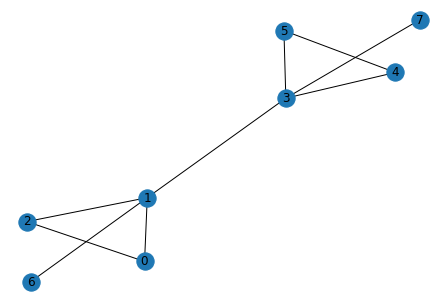

In [10]:
nx.draw(graph, with_labels=True)

In [13]:

from periodictable import core, covalent_radius, elements
from pprint import pprint
covalent_radius.init(elements)
# pt[6].covalent_radius
pprint({el:el.covalent_radius for el in elements if el.covalent_radius != None and el.covalent_radius > 2*0.76})

{Sm: 1.98,
 Pr: 2.03,
 Na: 1.66,
 K: 2.03,
 Pm: 1.99,
 Nd: 2.01,
 Hf: 1.75,
 Yb: 1.87,
 Lu: 1.87,
 Ho: 1.92,
 Ra: 2.21,
 Fr: 2.6,
 Eu: 1.98,
 W: 1.62,
 Ta: 1.7,
 Tm: 1.9,
 Er: 1.89,
 Dy: 1.92,
 Tb: 1.94,
 Gd: 1.96,
 Mo: 1.54,
 Nb: 1.64,
 Zr: 1.75,
 Ce: 2.04,
 La: 2.07,
 Ba: 2.15,
 Cs: 2.44,
 Y: 1.9,
 Sr: 1.95,
 Rb: 2.2,
 V: 1.53,
 Ti: 1.6,
 Sc: 1.7,
 Ca: 1.76,
 Cm: 1.69,
 Ac: 2.15,
 Pu: 1.87,
 Am: 1.8,
 Pa: 2.0,
 Th: 2.06,
 Np: 1.9,
 U: 1.96}


In [14]:
pt = core.PeriodicTable(table="H=1")
pt[4]

Be

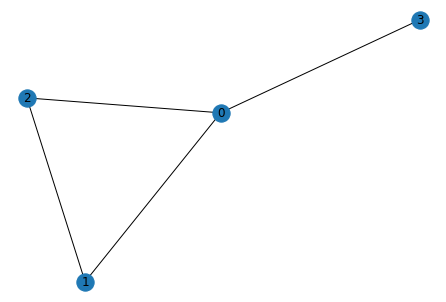

In [9]:
a = np.array([[0,0,0],
              [0,1,0],
              [1,0,0],
              [-1,-1,0]])

matrix = np.zeros((len(a),len(a)))
for i in range(len(a)):
    for j in range(i,len(a)):
        if np.linalg.norm(a[i]-a[j]) < 2:
            matrix[i][j] = 1

matrix
graph = nx.from_numpy_matrix(matrix)
# graph.nodes()
nx.draw(graph, with_labels=True)

[7.239738706798578, 5.902242426439336, 5.111175364548013, 9.871068754510102]


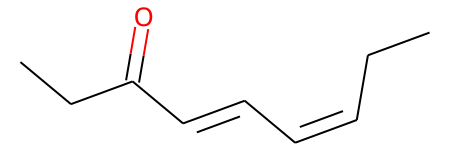

In [34]:
from subprocess import DEVNULL, STDOUT, check_call
def _get_ensemble_energies(filename):
    '''
    Reads file and returns an rdkit.Mol object with the first molecule
    and a list with the computed energy of all molecules at MMFF level.

    '''
    sdf_name = filename.split('.')[0] + '.sdf'
    check_call(f'obabel {filename} -o sdf -O {sdf_name}'.split(), stdout=DEVNULL, stderr=STDOUT)    # Bad, we should improve this

    mols = Chem.SDMolSupplier(sdf_name)
    # mols = [Chem.AddHs(m) for m in supplier]
    # mols = [m for m in supplier]
    energies = []
    for m in mols:
        # m = Chem.AddHs(m)
        # print(m.GetNumAtoms())
        ff = AllChem.MMFFGetMoleculeForceField(m, AllChem.MMFFGetMoleculeProperties(m))
        ff.Initialize()
        # ff.Minimize(maxIts=200)
        energies.append(ff.CalcEnergy())

    # del mols
    # os.remove(sdf_name)

    return energies, mols

a, b = _get_ensemble_energies('../Resources/SN2/flex_ensemble.xyz')
print(a)
# Chem.AddHs(b[0])
b[0]
Chem.MolFromSmiles(Chem.MolToSmiles(b[0]))


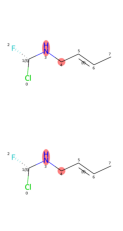

In [11]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
mol = Chem.MolFromSmiles('Cl[C@H](F)NC\C=C\C')
d = rdMolDraw2D.MolDraw2DCairo(500, 500) # or MolDraw2DSVG to get SVGs

rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=[3,4])


# mol.GetAtomWithIdx(2).SetProp('atomNote', 'foo')
# mol.GetBondWithIdx(0).SetProp('bondNote', 'bar')
d.drawOptions().addStereoAnnotation = True
d.drawOptions().addAtomIndices = True
d.DrawMolecule(mol)
# d.FinishDrawing()
d.WriteDrawingText('temp.png')
img1 = mpimg.imread('temp.png')
img2 = mpimg.imread('temp.png')

img = np.concatenate((img1, img2), axis=0)

plot = plt.imshow(img)
plt.axis('off')
plt.show()

In [51]:
help(plot)

nction that will be called whenever one of the
 |      `.Artist`'s properties changes.
 |      
 |      Parameters
 |      ----------
 |      func : callable
 |          The callback function. It must have the signature::
 |      
 |              def func(artist: Artist) -> Any
 |      
 |          where *artist* is the calling `.Artist`. Return values may exist
 |          but are ignored.
 |      
 |      Returns
 |      -------
 |      int
 |          The observer id associated with the callback. This id can be
 |          used for removing the callback with `.remove_callback` later.
 |      
 |      See Also
 |      --------
 |      remove_callback
 |  
 |  convert_xunits(self, x)
 |      Convert *x* using the unit type of the xaxis.
 |      
 |      If the artist is not in contained in an Axes or if the xaxis does not
 |      have units, *x* itself is returned.
 |  
 |  convert_yunits(self, y)
 |      Convert *y* using the unit type of the yaxis.
 |      
 |      If the artist is 